## Import & Data Load

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [52]:
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,20.0,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,20.0,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,20.0,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,10.0,...,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,10.0,...,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556


In [53]:
train.isnull().sum()

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
ID                         0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                153486
V_WIND                153486
AIR_TEMPERATURE       154365
BN                    153486
ATA_LT                     0
DUBAI                      0
BRENT                      0
WTI                        0
BDI_ADJ                    0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64

In [54]:
train['LENGTH'].fillna(train['LENGTH'].mean(), inplace=True)

In [55]:
def create_length_range(df):
    # 'RANGE_50' 컬럼을 숫자로 변환하는 함수 정의
    def map_range(value):
        return int(value // 50) * 50
    
    # 'LENGTH' 열을 기반으로 'RANGE_50' 컬럼을 생성
    df['RANGE_50'] = df['LENGTH'].apply(map_range)
    
    # 'RANGE_50' 값을 범주형(category)으로 변환
    df['RANGE_50'] = df['RANGE_50'].astype('category')
    
    return df




# 함수를 호출하여 데이터프레임에 'RANGE_50' 컬럼을 추가
train = create_length_range(train)
test = create_length_range(test)


In [56]:
def create_dist_category(df):
    # 'DIST' 값의 최소값과 최대값 확인
    min_dist = df['DIST'].min()
    max_dist = df['DIST'].max()

    # 범주 기준 설정
    categories = ['0 미만', '0-50 미만', '50-100 미만', '100-150 미만', '150-200 미만', '200 이상']

    # 'DIST_cat' 컬럼을 생성하는 함수 정의
    def map_dist(value):
        if value < 0:
            return '0 미만'
        elif 0 <= value < 50:
            return '0-50 미만'
        elif 50 <= value < 100:
            return '50-100 미만'
        elif 100 <= value < 150:
            return '100-150 미만'
        elif 150 <= value < 200:
            return '150-200 미만'
        else:
            return '200 이상'

    # 'DIST' 열을 기반으로 'DIST_cat' 컬럼을 생성
    df['DIST_cat'] = df['DIST'].apply(map_dist)

    # 'DIST_cat' 값을 범주형(category)으로 변환
    df['DIST_cat'] = df['DIST_cat'].astype('category')

    return df

# 함수를 호출하여 데이터프레임에 'DIST_cat' 컬럼을 추가
train = create_dist_category(train)
test = create_dist_category(test)


In [57]:
# def create_bdi_adj_category(df):
#     # 'BDI_ADJ' 값의 최소값과 최대값 확인
#     min_bdi_adj = df['BDI_ADJ'].min()
#     max_bdi_adj = df['BDI_ADJ'].max()

#     # 범주 기준 설정
#     categories = ['0-1000 미만', '1000-2000 미만', '2000-3000 미만', '3000-4000 미만', '4000-5000 미만', '5000 이상']

#     # 'BDI_ADJ_cat' 컬럼을 생성하는 함수 정의
#     def map_bdi_adj(value):
#         if value < 1000:
#             return '0-1000 미만'
#         elif 1000 <= value < 2000:
#             return '1000-2000 미만'
#         elif 2000 <= value < 3000:
#             return '2000-3000 미만'
#         elif 3000 <= value < 4000:
#             return '3000-4000 미만'
#         elif 4000 <= value < 5000:
#             return '4000-5000 미만'
#         else:
#             return '5000 이상'

#     # 'BDI_ADJ' 열을 기반으로 'BDI_ADJ_cat' 컬럼을 생성
#     df['BDI_ADJ_cat'] = df['BDI_ADJ'].apply(map_bdi_adj)

#     # 'BDI_ADJ_cat' 값을 범주형(category)으로 변환
#     df['BDI_ADJ_cat'] = df['BDI_ADJ_cat'].astype('category')

#     return df

def create_bdi_adj_numeric(df):
    # 'BDI_ADJ' 값의 최소값과 최대값 확인
    min_bdi_adj = df['BDI_ADJ'].min()
    max_bdi_adj = df['BDI_ADJ'].max()

    # 'BDI_ADJ' 열을 기반으로 'BDI_ADJ_numeric' 컬럼을 생성
    df['BDI_ADJ_numeric'] = ((df['BDI_ADJ'] - min_bdi_adj) // 1000).astype(int)

    return df

# 함수를 호출하여 데이터프레임에 'BDI_ADJ_cat' 컬럼을 추가
train = create_bdi_adj_numeric(train)
test = create_bdi_adj_numeric(test)


In [58]:
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR,RANGE_50,DIST_cat,BDI_ADJ_numeric
0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,20.0,...,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333,200,0-50 미만,1
1,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,20.0,...,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611,200,50-100 미만,1
2,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,20.0,...,14,65.30,66.39,56.94,603.193047,0.001743,98.827500,300,50-100 미만,0
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,10.0,...,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000,50,0-50 미만,0
4,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,10.0,...,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556,150,0-50 미만,0


## Data Pre-processing

In [59]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 
                        'SHIPMANAGER', 'FLAG', 'RANGE_50','DIST_cat']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)
# 결측치를 이전 해의 동일한 날짜 및 시간 값으로 대체하는 함수


Encoding features: 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]


In [60]:
train.isnull().sum()

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
ID                    0
BREADTH               0
BUILT                 0
DEADWEIGHT            0
DEPTH                 0
DRAUGHT               0
GT                    0
LENGTH                0
SHIPMANAGER           0
FLAG                  0
U_WIND                0
V_WIND                0
AIR_TEMPERATURE       0
BN                    0
ATA_LT                0
DUBAI                 0
BRENT                 0
WTI                   0
BDI_ADJ               0
PORT_SIZE             0
CI_HOUR               0
RANGE_50              0
DIST_cat              0
BDI_ADJ_numeric       0
year                  0
month                 0
day                   0
hour                  0
minute                0
weekday               0
dtype: int64

In [61]:
# dsf = train[['V_WIND','CI_HOUR','year','month','day', 'hour', 'minute', 'weekday']]
# #V_WIND"는 북쪽(North)으로 불어오는 풍속 구성 요소를 나타냅니다.
# # 양수 값은 북쪽으로 향하는 바람을 나타내며, 음수 값은 남쪽으로 향하는 바람을 나타냅니다.

# nan_rows = dsf[dsf['V_WIND'].isna()]

# nan_rows.head()

In [62]:
# def fill_missing_with_previous_year(df, columns):
#     for column in columns:
#         df[column].fillna(df.groupby(['year', 'month', 'day', 'hour'])[column].shift(365, axis=0), inplace=True)

# # 대체할 컬럼 리스트
# columns_to_fill = ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']

# # 각 컬럼에 대해 결측치 대체 수행
# fill_missing_with_previous_year(train, columns_to_fill)

# # 나머지 컬럼에 대해 평균값으로 결측치 대체
# train.fillna(train.mean(), inplace=True)

In [63]:
# # 결측치를 이전 해의 동일한 날짜 및 시간 값으로 대체하는 함수
# def fill_missing_with_previous_year(df, columns):
#     for column in columns:
#         df[column].fillna(df.groupby(['year', 'month', 'day', 'hour'])[column].shift(365, axis=0), inplace=True)

# # 대체할 컬럼 리스트
# columns_to_fill = ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']

# # 각 컬럼에 대해 결측치 대체 수행
# fill_missing_with_previous_year(trainss, columns_to_fill)

# # 나머지 컬럼에 대해 평균값으로 결측치 대체
# trainss.fillna(trainss.mean(), inplace=True)


In [64]:
# def create_length_range(df):
#     # 'RANGE_50' 컬럼을 숫자로 변환하는 함수 정의
#     def map_range(value):
#         return int(value // 50) * 50
    
#     # 'LENGTH' 열을 기반으로 'RANGE_50' 컬럼을 생성
#     df['RANGE_50'] = df['LENGTH'].apply(map_range)
    
#     # 'RANGE_50' 값을 범주형(category)으로 변환
#     df['RANGE_50'] = df['RANGE_50'].astype('category')
    
#     return df

# # 함수를 호출하여 데이터프레임에 'RANGE_50' 컬럼을 추가
# train = create_length_range(train)
# test = create_length_range(test)


In [65]:
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,CI_HOUR,RANGE_50,DIST_cat,BDI_ADJ_numeric,year,month,day,hour,minute,weekday
0,4,13,0,30.736578,24337,30.0,28,73100,20.0,10.0,...,3.048333,3,0,1,2020,10,15,4,3,3
1,4,14,2,63.220425,19552,30.0,15,37900,20.0,10.0,...,17.138611,3,3,1,2019,9,17,2,55,1
2,4,45,2,90.427421,20449,50.0,7,115000,20.0,10.0,...,98.827500,5,3,0,2019,2,23,6,43,5
3,8,75,1,0.000000,1689,10.0,33,1490,10.0,0.0,...,0.000000,8,0,0,2020,9,18,22,6,4
4,16,46,2,8.813725,2989,30.0,10,27600,10.0,10.0,...,96.030556,2,0,0,2022,8,13,12,57,5


## 모델 학습 및 특성 중요도 확인

Model Tune for xgb_model.


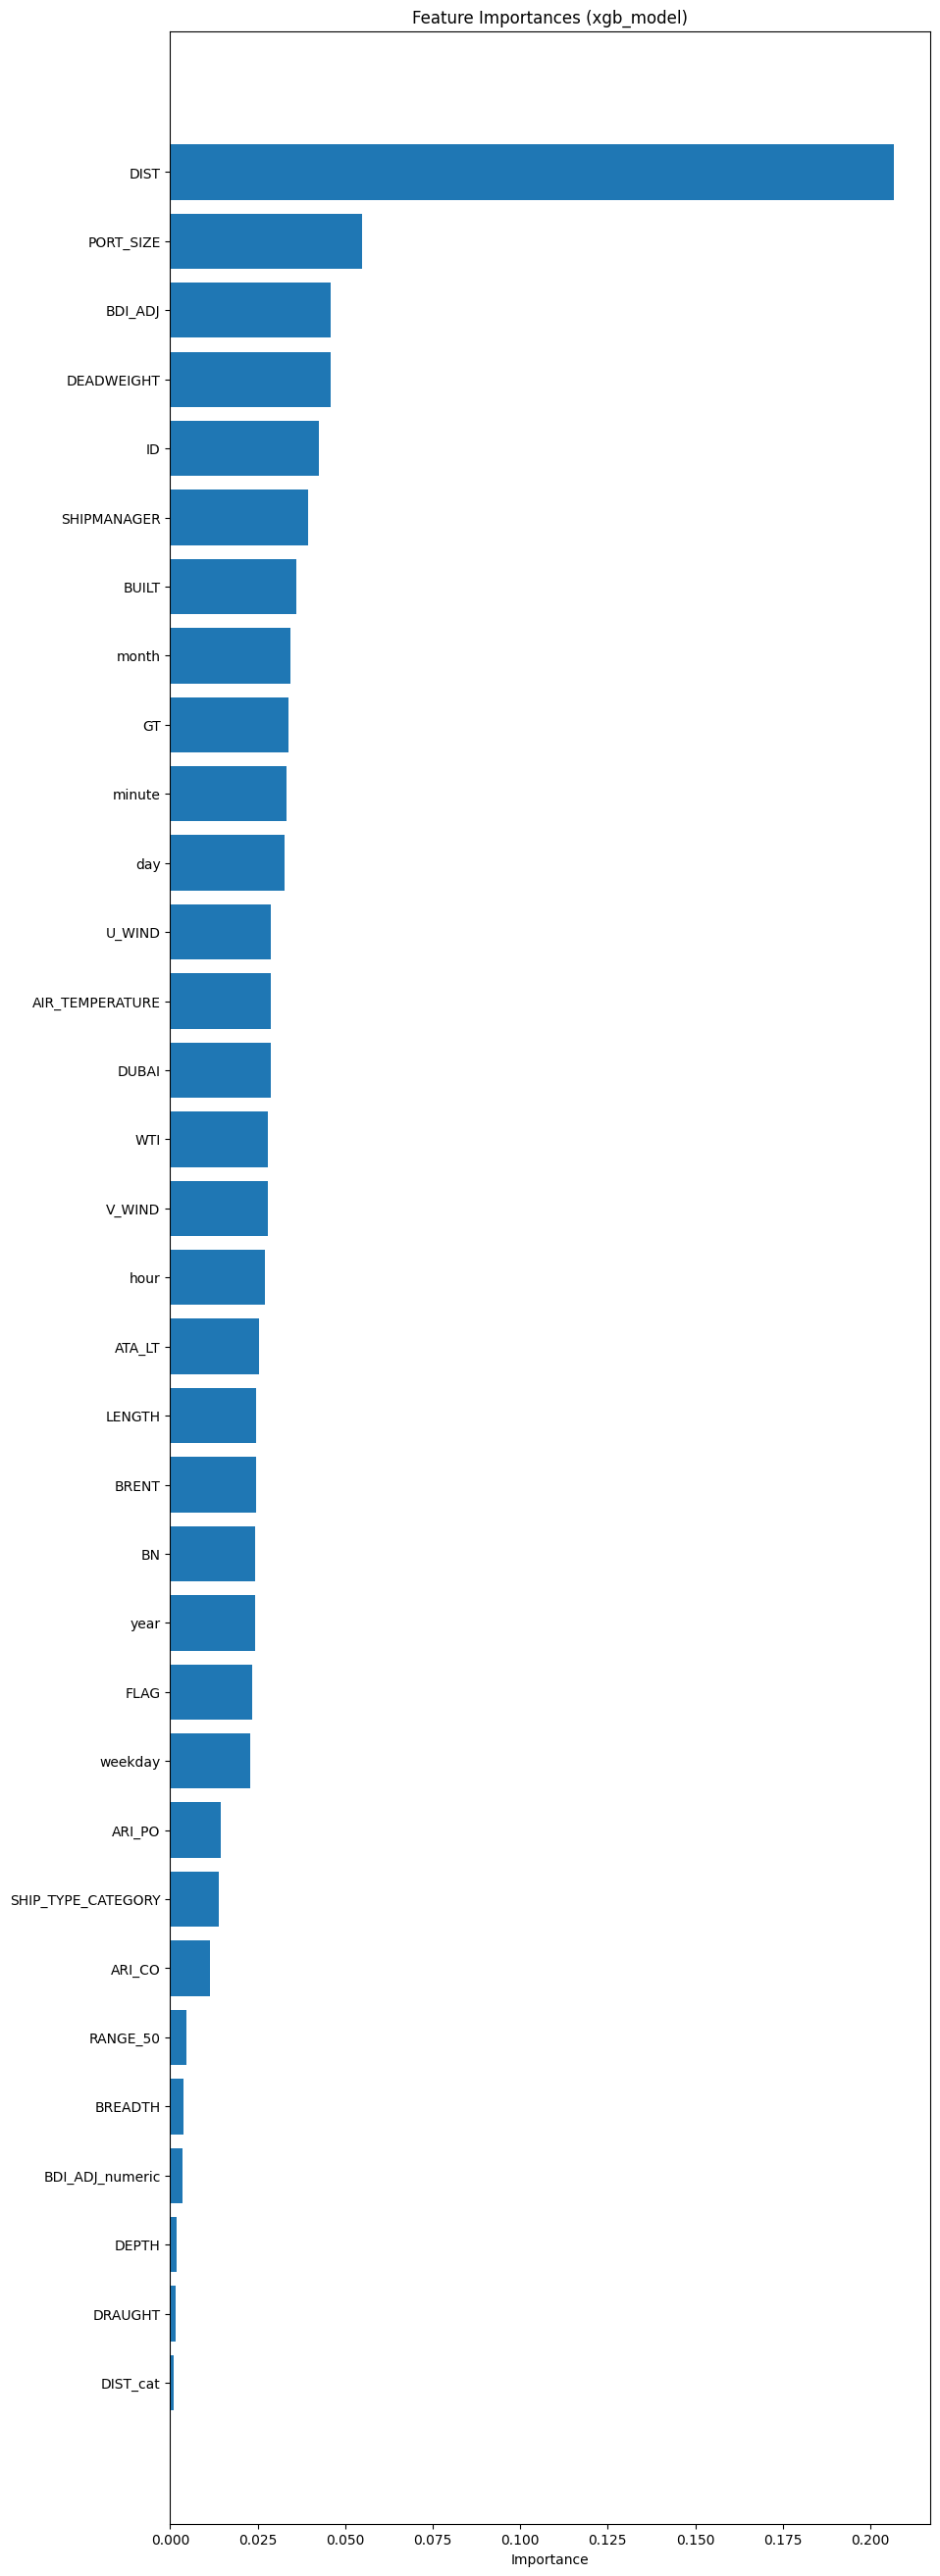

In [66]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


# 각 모델 학습 (이미 학습한 모델을 사용하려면 해당 부분을 제외하고 로드하세요)
xgb_model = RandomForestRegressor(random_state=42) #xgb.XGBRegressor(random_state=42)



def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(xgb_model, 
                                                        'xgb_model',
                                                        X_train, 
                                                        y_train)

## 특징 중요도로 부터 feature sections

In [67]:
threshold = 0.025 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [68]:
X_train_reduced.columns

Index(['DIST', 'ID', 'BUILT', 'DEADWEIGHT', 'GT', 'SHIPMANAGER', 'U_WIND',
       'V_WIND', 'AIR_TEMPERATURE', 'ATA_LT', 'DUBAI', 'WTI', 'BDI_ADJ',
       'PORT_SIZE', 'month', 'day', 'hour', 'minute'],
      dtype='object')

In [69]:
X_train_reduced["BDI_ADJ"].min()

286.8022972

In [70]:
X_train_reduced["BDI_ADJ"].max()

4795.865609

In [71]:
X_train_reduced.isnull().sum()

DIST               0
ID                 0
BUILT              0
DEADWEIGHT         0
GT                 0
SHIPMANAGER        0
U_WIND             0
V_WIND             0
AIR_TEMPERATURE    0
ATA_LT             0
DUBAI              0
WTI                0
BDI_ADJ            0
PORT_SIZE          0
month              0
day                0
hour               0
minute             0
dtype: int64

In [72]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X = X_train_reduced
y = y_train

# 학습 데이터와 검증 데이터로 분할합니다.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna를 사용하여 XGBoost 모델의 하이퍼파라미터 최적화를 수행하는 함수를 정의합니다.
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.1, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),  # 추가된 n_estimators 하이퍼파라미터
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
    }

    # XGBoost 모델을 생성합니다.
    model = xgb.XGBRegressor(**params, random_state=42)

    # 모델을 학습합니다.
    model.fit(X_train, y_train)

    # 검증 데이터로 예측을 수행합니다.
    y_pred = model.predict(X_valid)

    # 평균 제곱 오차(MSE)를 계산하여 최소화하도록 최적화합니다.
    mae = mean_absolute_error(y_valid, y_pred)

    return mae

# Optuna 스터디를 생성하고 실행합니다.
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=3000)  # 시행 횟수를 지정할 수 있습니다.

# 최적화된 하이퍼파라미터와 MSE 값을 출력합니다.
best_params = study.best_params
best_mae = study.best_value
print("Best Hyperparameters:", best_params)
print("Best MAE:", best_mae)


[I 2023-10-03 21:04:03,461] A new study created in memory with name: no-name-aef06cba-f9d9-4c9d-a813-3971b84c62b2
C:\Users\User\AppData\Local\Temp\ipykernel_36404\3126030626.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
C:\Users\User\AppData\Local\Temp\ipykernel_36404\3126030626.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
C:\Users\User\AppData\Local\Temp\ipykernel_36404\3126030626.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

[21:04:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth", "subsample" } are not used.



[I 2023-10-03 21:04:12,226] Trial 0 finished with value: 60.071886998209294 and parameters: {'booster': 'gblinear', 'lambda': 0.034819811705496126, 'alpha': 3.666615762506316e-07, 'max_depth': 8, 'eta': 1.6427995169350007e-05, 'gamma': 0.019070347471044986, 'subsample': 0.8518678818815876, 'n_estimators': 838, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 60.071886998209294.
C:\Users\User\AppData\Local\Temp\ipykernel_36404\3126030626.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
C:\Users\User\AppData\Local\Temp\ipykernel_36404\3126030626.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha

[21:04:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth", "subsample" } are not used.



[I 2023-10-03 21:05:01,184] Trial 2 finished with value: 411.1141786832213 and parameters: {'booster': 'gblinear', 'lambda': 4.029461586935446e-07, 'alpha': 2.6964391250979696e-06, 'max_depth': 1, 'eta': 0.19433731529208, 'gamma': 0.28266484330953656, 'subsample': 0.36238050593403226, 'n_estimators': 207, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 58.54280321695897.
C:\Users\User\AppData\Local\Temp\ipykernel_36404\3126030626.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
C:\Users\User\AppData\Local\Temp\ipykernel_36404\3126030626.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": tri

[21:14:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth", "subsample" } are not used.



[I 2023-10-03 21:14:06,253] Trial 6 finished with value: 61.0995038628603 and parameters: {'booster': 'gblinear', 'lambda': 0.0009337046923961339, 'alpha': 0.000139618586282632, 'max_depth': 2, 'eta': 1.5129577892164806e-08, 'gamma': 0.0005569088275809717, 'subsample': 0.9054012253825282, 'n_estimators': 381, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 51.62257054902744.
C:\Users\User\AppData\Local\Temp\ipykernel_36404\3126030626.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
C:\Users\User\AppData\Local\Temp\ipykernel_36404\3126030626.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha":

[21:15:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth", "subsample" } are not used.



[I 2023-10-03 21:15:33,837] Trial 9 finished with value: 68.74389033995293 and parameters: {'booster': 'gblinear', 'lambda': 3.946061477379592e-06, 'alpha': 2.0173226095065332e-06, 'max_depth': 6, 'eta': 0.0005988633358040013, 'gamma': 0.5425417063176579, 'subsample': 0.6525189539842704, 'n_estimators': 153, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 51.62257054902744.
C:\Users\User\AppData\Local\Temp\ipykernel_36404\3126030626.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
C:\Users\User\AppData\Local\Temp\ipykernel_36404\3126030626.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": 

In [234]:
import pandas as pd
from sklearn.model_selection import train_test_split


y =  y_train


X = X_train_reduced

# train 데이터와 test 데이터로 나누기
X_trains, X_tests, y_trains, y_tests = train_test_split(X, y, test_size=0.2,  random_state=42)


In [236]:
import xgboost as xgb  # 1. XGBoost 라이브러리 가져오기

# 2. XGBoost 모델 선택 및 초기화
xgb_model = xgb.XGBRegressor(subsample = 0.9500000000000002, n_estimators= 1000, 
                                min_child_weight= 5, max_depth = 7, learning_rate= 0.09999999999999999, 
                                gamma = 0.4, colsample_bytree = 0.7,random_state=42)

# 3. XGBoost 모델 학습
xgb_model.fit(X_trains, y_trains)

# 4. XGBoost 모델 평가 - MAE 계산
xgb_pred = xgb_model.predict(X_tests)
xgb_mae = mean_absolute_error(y_tests, xgb_pred)
print("XGBoost 모델의 MAE:", xgb_mae)


XGBoost 모델의 MAE: 37.7047378085995


In [235]:
import xgboost as xgb  # 1. XGBoost 라이브러리 가져오기

# 2. XGBoost 모델 선택 및 초기화
xgb_model = xgb.XGBRegressor(random_state=42)

# 3. XGBoost 모델 학습
xgb_model.fit(X_trains, y_trains)

# 4. XGBoost 모델 평가 - MAE 계산
xgb_pred = xgb_model.predict(X_tests)
xgb_mae = mean_absolute_error(y_tests, xgb_pred)
print("XGBoost 모델의 MAE:", xgb_mae)


XGBoost 모델의 MAE: 48.54165949682486


In [27]:
X_test_reduced.head()

,ARI_CO,SHIP_TYPE_CATEGORY,DIST,DEADWEIGHT,DRAUGHT,GT,LENGTH,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,year,month,weekday,RANGE_50
0,9,4,9.508139,5510,10.0,3720,100.0,97.88,96.49,89.55,766.977634,0.000256,2022,8,5,3
1,18,3,24.186684,109000,10.0,94400,330.0,98.14,104.64,100.60,1655.006791,0.002615,2022,3,6,7
2,20,2,0.000000,13700,10.0,8930,140.0,83.70,84.98,79.48,682.595117,0.000427,2023,1,2,3
3,9,1,0.000000,2840,10.0,1970,80.0,38.85,41.80,39.51,629.378100,0.000256,2016,8,1,2
4,18,3,19.834186,30700,10.0,26000,200.0,83.88,86.13,80.13,563.101921,0.002615,2023,1,1,5


In [237]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 1. 테스트 데이터 불러오기
test_data = X_test_reduced  # 테스트 데이터 파일 경로를 지정하세요.

# 2. 테스트 데이터 전처리 (필요한 전처리 과정을 X_test에 적용)
X_test = test_data # 테스트 데이터에서 'CI_HOUR' 열을 제외하거나 필요한 열만 선택
# 나머지 전처리 단계를 동일하게 적용 (예: 스케일링, 원핫 인코딩 등)

# 3. 랜덤 포레스트 모델을 사용하여 예측 수행
rf_pred = xgb_model.predict(X_test)

# # 예측 결과를 원하는 형식으로 저장하거나 활용할 수 있습니다.
# # 예를 들어, DataFrame으로 저장하고 CSV 파일로 내보낼 수 있습니다.
# predictions_df = pd.DataFrame({'Predicted_CI_HOUR': rf_pred})
# predictions_df.to_csv('predictions.csv', index=False)  # 예측 결과를 'predictions.csv' 파일로 저장


In [238]:
submit = pd.read_csv('./sample_submission.csv')

In [239]:
submit.head()

,SAMPLE_ID,CI_HOUR
0,TEST_000000,0
1,TEST_000001,0
2,TEST_000002,0
3,TEST_000003,0
4,TEST_000004,0


In [240]:
submit['CI_HOUR'] = rf_pred

In [241]:
submit.head()

,SAMPLE_ID,CI_HOUR
0,TEST_000000,72.079865
1,TEST_000001,441.817688
2,TEST_000002,0.682082
3,TEST_000003,7.271054
4,TEST_000004,89.438797


In [242]:
submit.to_csv('E:/ship/ship/models/baseline_submit_6_내일제출하자.csv', index=False)

## 이상치 제거
## scale
## feature section
## 앙상블
## atouai

In [35]:
# 모델 평가 - MAE 계산
from sklearn.metrics import mean_absolute_error

In [36]:
# ##Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH',
#        'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
#        'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
#        'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR',
#        'year', 'month', 'day', 'hour', 'minute', 'weekday'],
#       dtype='object')

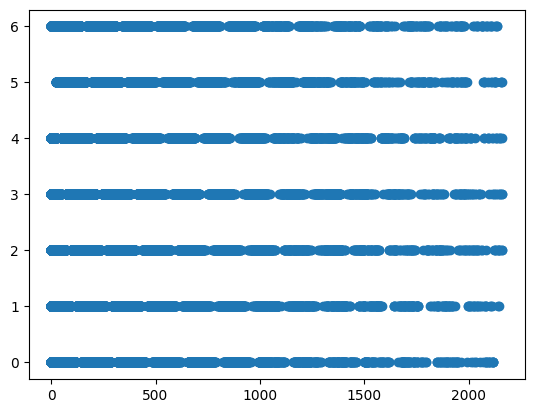

In [37]:
import matplotlib.pyplot as plt

plt.scatter(train['CI_HOUR'], train['weekday'])
plt.show()


## 모델 학습 및 특성 중요도 확인

Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3936
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 31
[LightGBM] [Info] Start training from score 61.877118


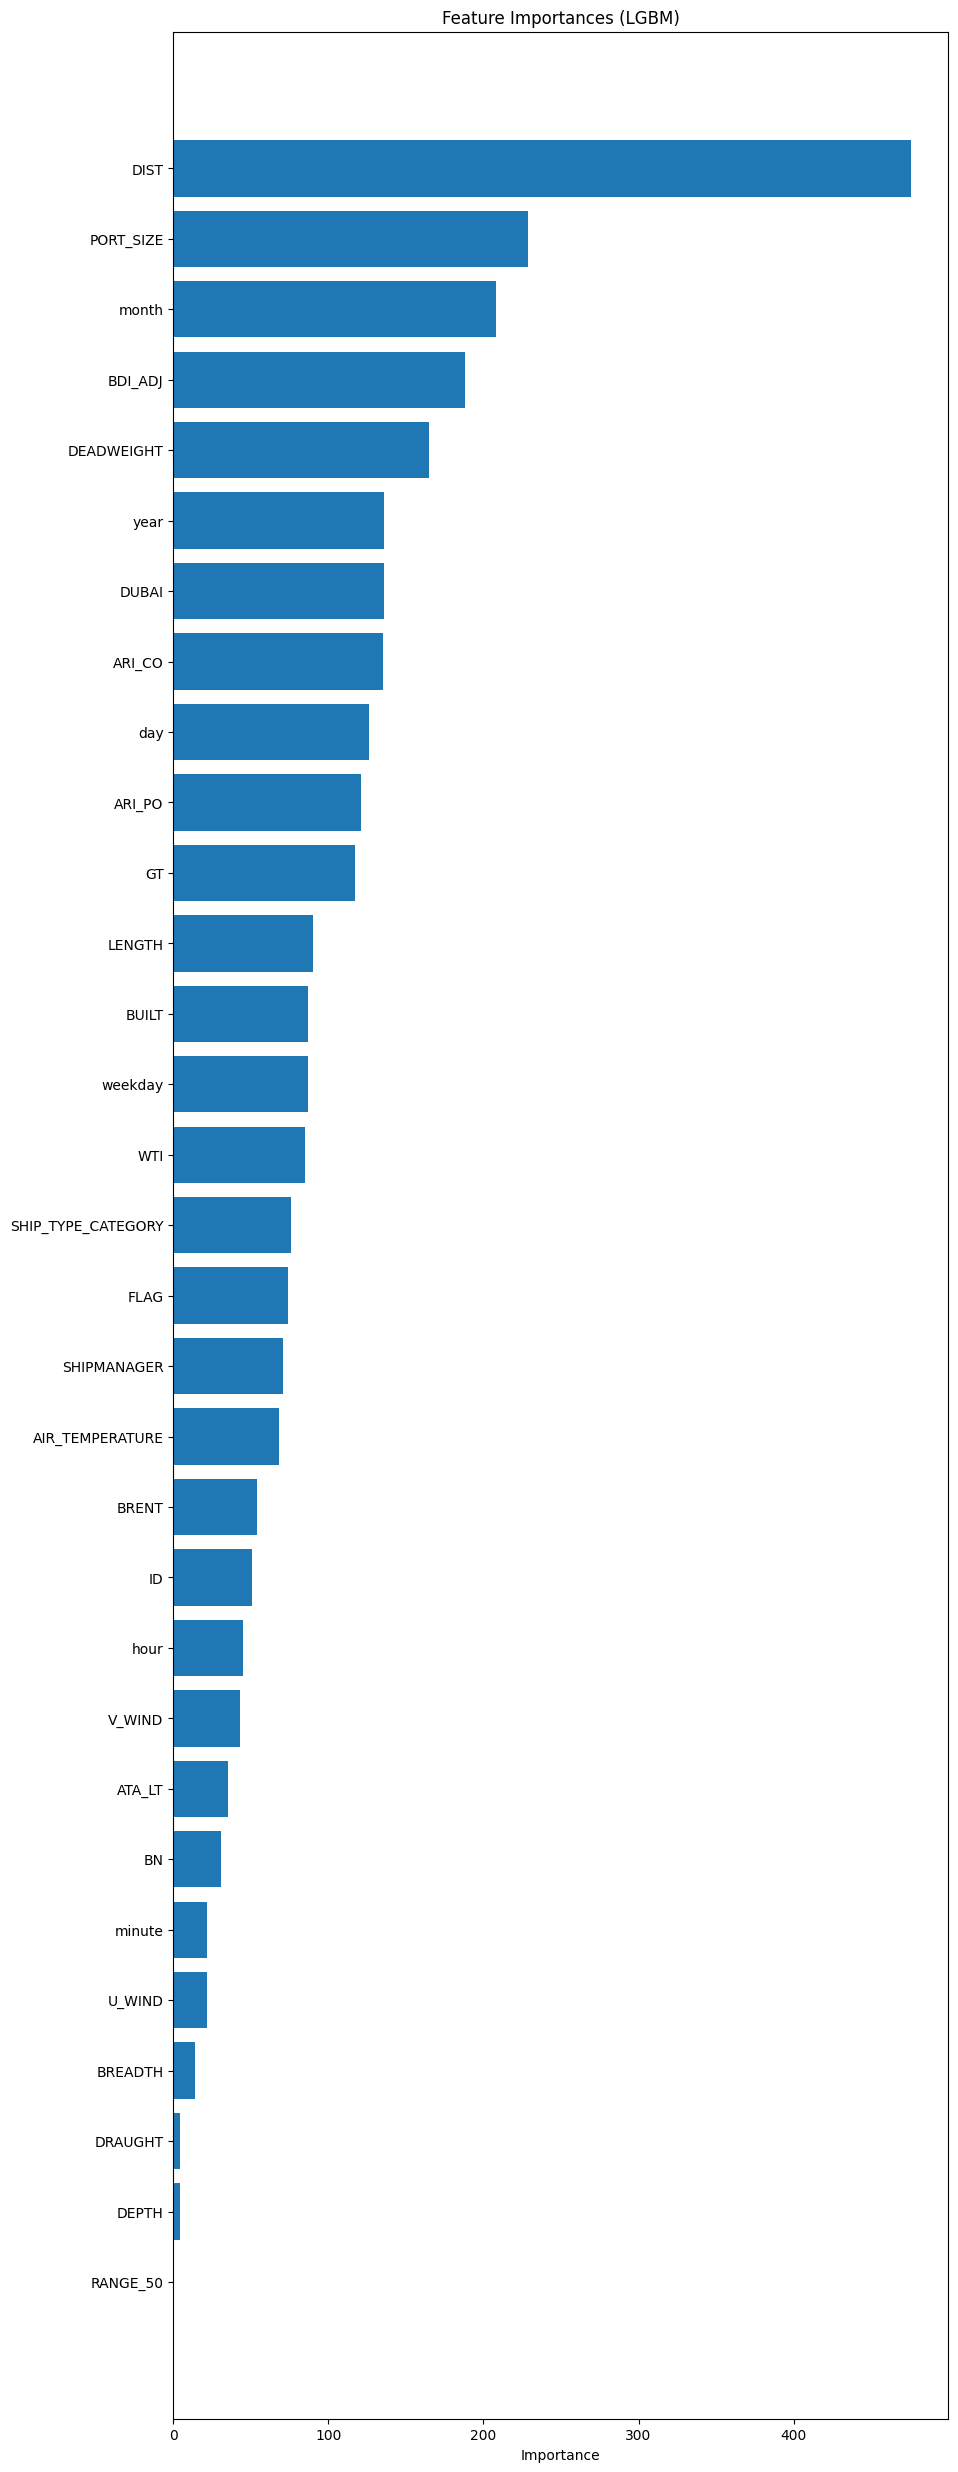

In [38]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

## 특성 중요도로부터 Feature Selection

In [39]:
threshold = 85 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

## K-Fold Model Fitting & Validation

In [40]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]
    
    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)
    
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
    
    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 62.047288


Processing folds:  20%|██        | 1/5 [00:01<00:04,  1.15s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.719969


Processing folds:  40%|████      | 2/5 [00:02<00:03,  1.11s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.754815


Processing folds:  60%|██████    | 3/5 [00:03<00:02,  1.15s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.868218


Processing folds:  80%|████████  | 4/5 [00:04<00:01,  1.14s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.995298


Processing folds: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]

Validation : MAE scores for each fold: [52.64372300947119, 54.21259302652475, 53.81358286835421, 53.27999456243711, 53.30398273099311]
Validation : MAE: 53.45077523955608


## Submission

In [41]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./baseline_submit.csv', index=False)